## Benchmarks and testing
Here we report the results from previous (very long) runs done on the other two notebooks, for benchmarking purposes. The times were saved on text files included in the .zip archive.

### RDD

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
uniform_loss = [72070,44580,41778,40669,40152,39885,39786,39026,38920,38795,38314,35832,29053,25131,25068]
parallel_loss = [27588,26281,24891,24372,24186,24011,23806,23557,23427,23321,23268,23251,23242,23238,23237]
index = [i+1 for i in range(15)]

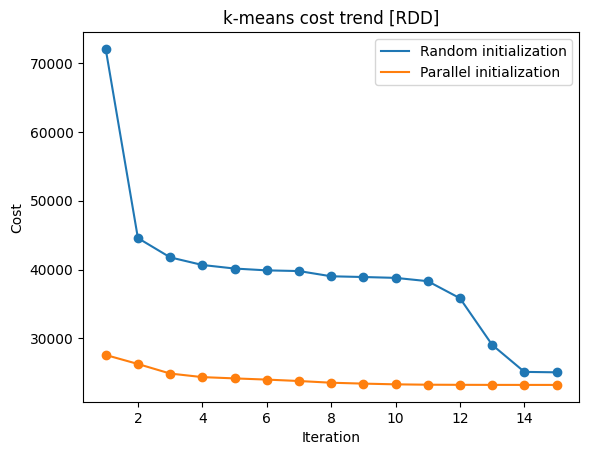

In [3]:
plt.plot(index,uniform_loss, label="Random initialization")
plt.plot(index,parallel_loss, label="Parallel initialization")
plt.scatter(index,uniform_loss)
plt.scatter(index,parallel_loss)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("k-means cost trend [RDD]")
plt.show()

### Initialization and clustering times

```python
n_iter = 5
u_in = []
u_cl = []
p_in = []
p_cl = []

for i in range(n_iter):
    t1 = time.time()
    rand_c = stupid_init(kdd_rdd,k)
    t2 = time.time()
    u_in.append(t2-t1)
    
    t1=time.time()
    rand_c = k_means(kdd_rdd, rand_c, 15)
    t2 = time.time()
    u_cl.append(t2-t1)
    
    t1=time.time()
    par_c = parallel_init(kdd_rdd, k, 10, 15)
    t2 = time.time()
    p_in.append(t2-t1)
    
    t1=time.time()
    par_c = k_means(kdd_rdd, par_c, 15)
    t2 = time.time()
    p_cl.append(t2-t1)
```

In [4]:
u_in = [6.618762731552124,12.464976072311401,12.385783672332764,13.178653240203857,12.278600692749023]
u_cl = [147.88093280792236,146.70449137687683,267.2069208621979,269.5066409111023,268.15031909942627]
p_in = [198.52358055114746,227.87116169929504,230.42344212532043,213.24074816703796,222.1819624900818]
p_cl = [311.72772574424744,165.01162958145142,206.04673528671265,206.08331179618835,163.70856761932373]

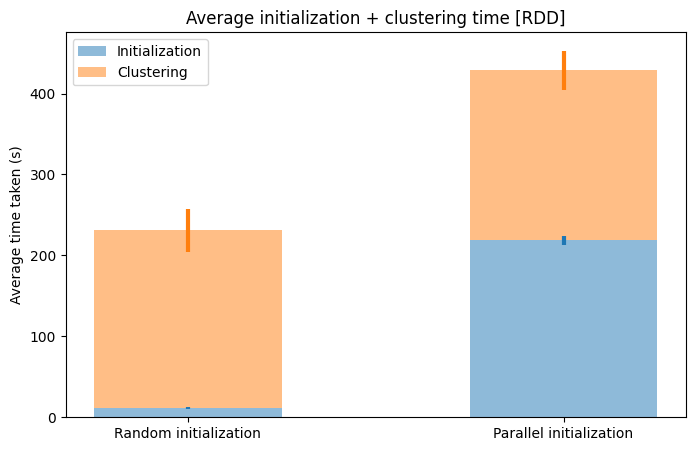

In [5]:
init_lab = ["Random initialization", "Parallel initialization"]
init_idx = list(range(len(init_lab)))
time_data = {
    "Initialization": [[np.mean(u_in),np.mean(p_in)], [np.std(u_in)/np.sqrt(5), np.std(p_in)/np.sqrt(5)]],
    "Clustering": [[np.mean(u_cl),np.mean(p_cl)], [np.std(u_cl)/np.sqrt(5), np.std(p_cl)/np.sqrt(5)]]
}

fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(init_idx))
for lab, val in time_data.items():
    p = ax.bar(init_idx, val[0], 0.5, label=lab, bottom=bottom, alpha=0.5)
    p1 = ax.errorbar(init_idx, val[0]+bottom, yerr=val[1], linewidth=0, elinewidth=3)
    bottom += val[0]
ax.set_xticks(init_idx, init_lab)
ax.set_ylabel("Average time taken (s)")
ax.set_title("Average initialization + clustering time [RDD]")
plt.legend()
plt.show()

### Partition number optimization

```python
partitions = [8,16,32,64,128,256]
n_cycles = 3
rand_times = []
par_times = []

for j in partitions:
    data = kdd[0]
    n_slices = j

    kdd_rdd = sc.parallelize(
        [(0, {"features": data[i], "label": labels[i]}) for i in range(n_samples)],
        numSlices=n_slices
    )
    
    kdd_rdd = kdd_rdd.map(remove_bytes)
    
    data_mins = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.minimum(x, y))

    data_maxs = kdd_rdd \
    .map(lambda x: x[1]["features"]) \
    .reduce(lambda x, y: np.maximum(x, y))

    kdd_rdd = kdd_rdd.map(lambda x: rescale(x, data_mins, data_maxs))

    print(f"Starting with partition number: {kdd_rdd.getNumPartitions()}")
    
    for i in range(n_cycles):
        t1 = time.time()
        rand_c = stupid_init(kdd_rdd,k)
        rand_c = k_means(kdd_rdd, rand_c, 15)
        t2 = time.time()
        print(f"Random init, partition size {j}, time {t2-t1}")
        rand.append([j,t2-t1])
    
        t1=time.time()
        par_c = parallel_init(kdd_rdd, k, 10, 15)
        par_c = k_means(kdd_rdd, par_c, 15)
        t2 = time.time()
        print(f"Parallel init, partition size {j}, time {t2-t1}")
        par.append(t2-t1)
```

In [6]:
part_size = [8,16,32,64,128,256]
rand_times = [[41, 31, 44],[73, 31, 70],[262, 172, 146],[198, 206, 136],[349, 205, 243],[385, 478, 492]]
par_times = [[224, 203, 184], [278, 191, 182], [318, 296, 297],[343, 284, 279], [444, 457, 560], [682, 717, 782]]

rand_mean = np.mean(rand_times, axis=-1)
rand_std = np.std(rand_times, axis=-1)

par_mean = np.mean(par_times, axis=-1) 
par_std = np.std(par_times, axis=-1)

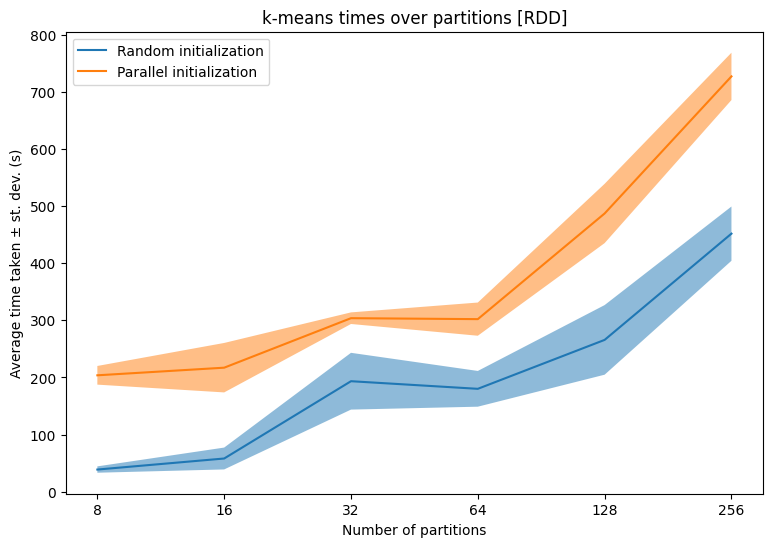

In [7]:
n_parts = ["8", "16", "32", "64", "128", "256"]
part_idx = list(range(len(n_parts)))
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(part_idx, rand_mean, label = "Random initialization")
ax.fill_between(part_idx, rand_mean + rand_std, rand_mean - rand_std, alpha=0.5)
ax.plot(part_idx, par_mean, label = "Parallel initialization")
ax.fill_between(part_idx, par_mean + par_std, par_mean - par_std, alpha=0.5)
ax.set_ylabel("Average time taken ± st. dev. (s)")
ax.set_xlabel("Number of partitions")
ax.set_xticks(part_idx, n_parts)
plt.title("k-means times over partitions [RDD]")
plt.legend()
plt.show()

## Dataframe

In [8]:
uniform_loss = [189861, 83352,71201,70870,70824,70804,70778,70765,70764,70763,70763]
parallel_loss = [33347,24966,24436,24233,24156,24100,24084,24077,24074,24072,24070]
minib_loss = [2043090,220926,160393,48485,37943,28461,27525,26949,26340,26165,26062]
index = [i+1 for i in range(11)]

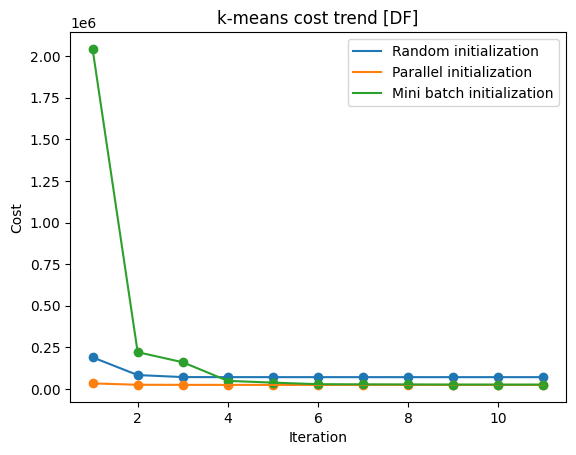

In [9]:
plt.plot(index,uniform_loss, label="Random initialization")
plt.plot(index,parallel_loss, label="Parallel initialization")
plt.plot(index,minib_loss, label="Mini batch initialization")
plt.scatter(index,uniform_loss)
plt.scatter(index,parallel_loss)
plt.scatter(index,minib_loss)
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("k-means cost trend [DF]")
plt.show()

```python
n_runs = 5

assign_t = []
cluster_t = []
    
for i in range(n_runs):
    start_ass = time.time()
    a = random_choice_init(kdd,len(attacks))
    start_clu = time.time()
    unif_data, _ , u_cost = kmeans(kdd, a, max_iter=10, local_centr=True, return_cost=True, break_perc=0.999)
    end = time.time()
    assign_t.append(start_clu - start_ass)
    cluster_t.append(end - start_clu)
    
    start_ass = time.time()
    c = kmeans_parallel(kdd, len(attacks), 5.5)
    start_clu = time.time()
    per_data, _ , p_cost = kmeans(kdd, c, max_iter=10, local_centr=True, return_cost=True, break_perc=0.99)
    end = time.time()
    assign_t.append(start_clu-start_ass)
    cluster_t.append(end - start_clu)

```

In [10]:
u_in = [5.075510025024414, 5.444869041442871, 5.344725131988525,5.494255781173706,5.400717496871948]
u_cl = [501.5756275653839, 694.3763709068298, 581.4217898845673, 682.342541217804, 456.050585269928]
p_in = [309.67773365974426, 492.0955755710602, 463.70165395736694, 338.9116213321686, 343.69567251205444]
p_cl = [391.4295184612274, 394.46403527259827, 394.6167731285095, 771.9483833312988, 494.48830223083496]

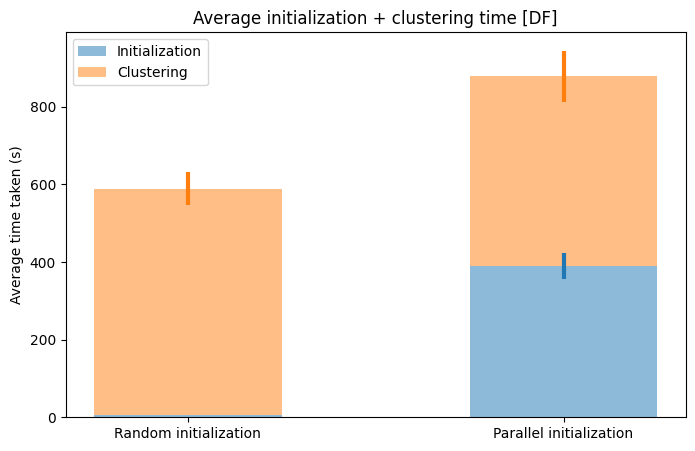

In [11]:
init_lab = ["Random initialization", "Parallel initialization"]
init_idx = list(range(len(init_lab)))
time_data = {
    "Initialization": [[np.mean(u_in),np.mean(p_in)], [np.std(u_in)/np.sqrt(5), np.std(p_in)/np.sqrt(5)]],
    "Clustering": [[np.mean(u_cl),np.mean(p_cl)], [np.std(u_cl)/np.sqrt(5), np.std(p_cl)/np.sqrt(5)]]
}

fig, ax = plt.subplots(figsize=(8, 5))
bottom = np.zeros(len(init_idx))
for lab, val in time_data.items():
    p = ax.bar(init_idx, val[0], 0.5, label=lab, bottom=bottom, alpha=0.5)
    p1 = ax.errorbar(init_idx, val[0]+bottom, yerr=val[1], linewidth=0, elinewidth=3)
    bottom += val[0]
ax.set_xticks(init_idx, init_lab)
ax.set_ylabel("Average time taken (s)")
ax.set_title("Average initialization + clustering time [DF]")
plt.legend()
plt.show()

```python
partitions = [8,16,32,64,128,256]
unif_time_m = []
#unif_time_std = []
parallel_time_m =[]
#parallel_time_std = []

n_runs = 2

for j in partitions:
    
    print(f"starting partition {j}")
    
    kdd = kdd.repartition(j)
    kdd.rdd.getNumPartitions()
    
    unif_t = []
    par_t = []
    
    for i in range(n_runs):
        t1 = time.time()
        
        a = random_choice_init(kdd,len(attacks))
        unif_data, _ , u_cost = kmeans(kdd, a, max_iter=10, local_centr=True, return_cost=True, break_perc=0.999)
        t2 = time.time()
        unif_t.append(t2 - t1)
        print(f"iteration {i}, unif. clustering time {t2-t1}")
    
        c = kmeans_parallel(kdd, len(attacks), 5.5)
        per_data, _ , p_cost = kmeans(kdd, c, max_iter=10, local_centr=True, return_cost=True, break_perc=0.99)
        t3 = time.time()
        par_t.append(t3-t2)
        print(f"iteration {i}, parallel clustering time {t3-t2}")
        
        
    unif_time_m.append(np.mean(unif_t))
    #unif_time_std.append(np.std(unif_t))
    parallel_time_m.append(np.mean(par_t))
    #parallel_time_std.append(np.std(par_t))
```

In [12]:
rand_times = [[743, 407, 287], [361, 422, 633], [186, 911, 879],[734, 750, 631], [523, 420, 736]]
par_times = [[683, 727, 670], [922, 723, 871], [662, 739, 1294],[1026, 903, 855], [865, 810, 916]]

rand_mean = np.mean(rand_times, axis=-1)
rand_std = np.std(rand_times, axis=-1)

par_mean = np.mean(par_times, axis=-1) 
par_std = np.std(par_times, axis=-1)
print(par_std/par_mean)

[0.03517838 0.1006326  0.31340151 0.07760117 0.05011724]


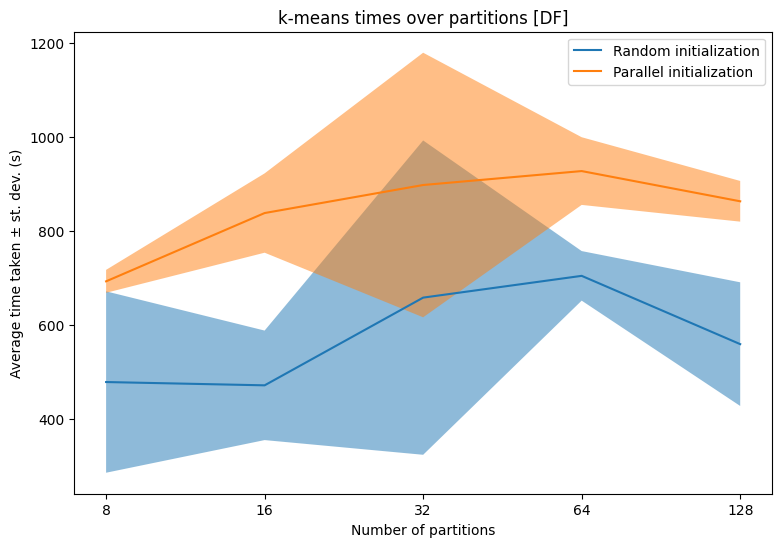

In [13]:
n_parts = ["8", "16", "32", "64", "128"]
part_idx = list(range(len(n_parts)))
fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(part_idx, rand_mean, label = "Random initialization")
ax.fill_between(part_idx, rand_mean + rand_std, rand_mean - rand_std, alpha=0.5)
ax.plot(part_idx, par_mean, label = "Parallel initialization")
ax.fill_between(part_idx, par_mean + par_std, par_mean - par_std, alpha=0.5)
ax.set_ylabel("Average time taken ± st. dev. (s)")
ax.set_xlabel("Number of partitions")
ax.set_xticks(part_idx, n_parts)
plt.title("k-means times over partitions [DF]")
plt.legend()
plt.show()